In [2]:
# !pip install hurst
# !pip install rarfile
# !pip install pyunpack
# !pip install patool
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from hurst import compute_Hc
import time
from scipy.stats import skew, kurtosis
import warnings
from sklearn.decomposition import PCA
from scipy.signal import spectrogram
from pyunpack import Archive
import os
import rarfile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from IPython import display
display.set_matplotlib_formats('svg')

warnings.filterwarnings("ignore")


/var/folders/f0/yk_38ks9693585hklt0mrt9h0000gp/T/ipykernel_84538/2516550392.py:25: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [21]:
# Ketan's paths
EEG_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_eegs/'
SPEC_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_spectrograms/'
DIRECTORY = ''
feature_file_path = '/Users/ketanjaltare1/Desktop/Competitions/Features_wf_all.parquet'

# Load the data and remove any columns with NANs - Maybe we can later look at how to use these columns. 
All_features = pd.read_parquet(feature_file_path)
rel_keys = All_features.keys()[15:-6]
onlyfeatures = All_features[rel_keys]
onlyfeatures_cleaned = onlyfeatures.dropna(axis=1, how='any')
print(onlyfeatures_cleaned.shape)

(106800, 359)


In [ ]:
# Fabien's paths
EEG_PATH = 'D:/Kaggle/2024/Harmful_brain_activity_classification/train_eeg/'
SPEC_PATH = ''
DIRECTORY = 'D:/Kaggle/2024/Harmful_brain_activity_classification/'

In [4]:
# For eeg data
def loadeeg(path):
    eeg = pd.read_parquet(path)
#     eeg = eeg.replace(np.nan, 0) # There are missing values in some files. It makes the PCA analysis fail, so we need to replace them. I have chosen 0 for practicality
    return (eeg)

def hurst_fct(x):
    try:
        out = compute_Hc(x, simplified=True)[0]
    except:
        out = np.nan
    return out
        

In [5]:
# Functions to load a single dataset
train = pd.read_csv(DIRECTORY + 'train.csv')
All_features = pd.read_parquet(feature_file_path)

# dataframe dimensions
print(train.shape)
print(All_features.shape)

(106800, 15)
(106800, 404)


In [ ]:
# Samples where there is no consensus
eegids = train.eeg_id.unique()
no_agree = []
for id in eegids:
    temp = train.loc[train.eeg_id == id, 'expert_consensus']
    if len(temp.unique()) > 1:
        no_agree.append(id)
        print(id)
    
print(train.loc[train.eeg_id == no_agree[1],:])

In [6]:
# Try computing synchronisation
from scipy.signal import hilbert
from scipy.signal import iirfilter, filtfilt

# Define your frequency bands as a list of tuples (lowcut, highcut)
frequency_bands = [(1, 4), (4, 8), (8, 12), (12, 30), (30, 95)]  # Example bands in Hz
fs = 200.0  # Sampling frequency
order = 5  # Filter order - This is a trade off in terms of accuracy and time. The lower the faster, but less accurate/narrow
filters = []

# This is the first low pass filter. All the others which are defined in the loop are bandpass filters
b, a = iirfilter(N=order, Wn=1, fs=fs, btype='lowpass', ftype='butter', output='ba')
filters.append((b,a))

for lowcut, highcut in frequency_bands:
    b, a = iirfilter(N=order, Wn=[lowcut, highcut], fs=fs, btype='band', ftype='butter', output='ba')
    filters.append((b,a))    

# Function for synchronisation calculation
def compute_synch(filters,data):
    all_synch = np.empty((0, len(filters)))
    for i, (b, a) in enumerate(filters):
        filtered_signal = filtfilt(b, a, data, axis = 0)

        # Calculate the PLV matrix
        try:
            n_points, n_channels, n_reps = filtered_signal.shape # We can change this if we decide to compute on a 2D matrix
        except:
            n_points, n_channels = filtered_signal.shape
            n_reps = 1
            
        plv_matrix = np.zeros((n_channels, n_channels, n_reps))

        # Compute the analytical signal for each channel
        analytical_signals = hilbert(filtered_signal, axis=0)

        # Extract phases
        phases = np.angle(analytical_signals)
        if len(phases.shape) <= 2:
            phases = phases[:,:,np.newaxis]

        # Compute PLV for each pair of channels
        for i in range(n_channels):
            for j in range(i, n_channels):
                phase_diff = phases[:,i,:] - phases[:,j,:]
                plv = np.abs(np.mean(np.exp(1j * phase_diff),axis=0))
                plv_matrix[i, j,:] = plv # Upper triangle of Symmetric matrix
        synch = plv_matrix[np.triu_indices(n_channels,k = 1)].T
        if all_synch.shape[0] == 0:
            all_synch = synch
        else:
            all_synch = np.hstack((all_synch, synch))
        
    return all_synch





def kl_divergence_loss(output, target, epsilon=1e-15):
    # Ensure the output is in log form and target is probabilities
#     log_output = F.log_softmax(output, dim=1)
    
    # Clip target to avoid division by zero or log(0)
    target = torch.clamp(target, epsilon, 1 - epsilon)
    
    # Calculate KL Divergence
    kl_div = target * torch.log(target / torch.exp(target))
    
    # Return mean KL Divergence across the batch
    return kl_div.sum(dim=1).mean()



In [ ]:
# Compute synchronisation for all the data and save with the rest of the features
time_eeg = np.arange(-25, 25+ (1/200), (1/200))
Starttime = time.time()
nums = np.arange(171*len(filters))
Synch_cols = ['Synch' + str(num) for num in nums]
Synch_data = np.empty((0,len(Synch_cols)))
eeg_ids = All_features.eeg_id.values
current_id = 0
error_id = []
error_offset = []
processed_ids = []
processed_offsets = []

for idx, id in enumerate(eeg_ids):
    if current_id == id:
        continue
    current_id = id
    path = f'{EEG_PATH}{int(id)}.parquet'
    fulleeg = loadeeg(path).to_numpy()[:,:19] # Excluding the ECG channel here
    offset = All_features.eeg_label_offset_seconds[All_features.eeg_id == id].values
    tempdat = np.zeros((len(time_eeg)-1,19,len(offset)))
    tempy = All_features.eeg_id[All_features.eeg_id == id]
    for offind, off in enumerate(offset):
        if np.isnan(fulleeg[int(off)*200:(((int(off)+50)*200)),:]).any(): #Not sure why the nans are appearing.
            print(f'Nans found in {id} at offset: {off}')
            error_id.append(id)
            error_offset.append(off)
            continue
        tempdat[:,:,offind] = fulleeg[int(off)*200:(((int(off)+50)*200)),:]
    onlysynch = compute_synch(filters,tempdat)
    Synch_data = np.vstack((Synch_data,onlysynch))
    processed_ids.extend(tempy)

    
print(f'Time Taken: {(time.time() - Starttime)/60} minutes for {Synch_data.shape[0]} rows')

In [22]:
# Concatenate and save - also save the errors
nums = np.arange(Synch_data.shape[1])
Synch_cols = ['Synch' + str(num) for num in nums]
Synch_data_frame = pd.DataFrame(Synch_data, columns=Synch_cols)
All_features = pd.concat([All_features, Synch_data_frame], axis=1)
All_features.to_parquet('/Users/ketanjaltare1/Desktop/Competitions/Combined_Features_compressed.parquet',compression='snappy')
errors = pd.DataFrame({'Error_id': error_id, 'Error_offset': error_offset})
errors.to_parquet('/Users/ketanjaltare1/Desktop/Competitions/Combined_Features_errors.parquet')

Columns with NaNs: ['T3_hurst_before', 'T4_hurst_before', 'FR_hurst_before', 'FL_hurst_before', 'BR_hurst_before', 'BL_hurst_before', 'CentrFB_hurst_before', 'CentrLR_hurst_before', 'T3_hurst_during', 'T4_hurst_during', 'FR_hurst_during', 'FL_hurst_during', 'BR_hurst_during', 'BL_hurst_during', 'CentrFB_hurst_during', 'CentrLR_hurst_during', 'T3_hurst_after', 'T4_hurst_after', 'FR_hurst_after', 'FL_hurst_after', 'BR_hurst_after', 'BL_hurst_after', 'CentrFB_hurst_after', 'CentrLR_hurst_after', 'Synch0', 'Synch1', 'Synch2', 'Synch3', 'Synch4', 'Synch5', 'Synch6', 'Synch7', 'Synch8', 'Synch9', 'Synch10', 'Synch11', 'Synch12', 'Synch13', 'Synch14', 'Synch15', 'Synch16', 'Synch17', 'Synch18', 'Synch19', 'Synch20', 'Synch21', 'Synch22', 'Synch23', 'Synch24', 'Synch25', 'Synch26', 'Synch27', 'Synch28', 'Synch29', 'Synch30', 'Synch31', 'Synch32', 'Synch33', 'Synch34', 'Synch35', 'Synch36', 'Synch37', 'Synch38', 'Synch39', 'Synch40', 'Synch41', 'Synch42', 'Synch43', 'Synch44', 'Synch45', 'Synch

3542

In [167]:
# Load data for synchronisation computation
time_eeg = np.arange(-25, 25+ (1/200), (1/200))
Starttime = time.time()
labels = train.expert_consensus.unique()
numeegs = 200 # Number of datasets to load from each type
TD_data = {}
featurelength = 171*len(filters) + onlyfeatures_cleaned.shape[1]
Synch_data = np.empty((0,featurelength))
TD_ydata = []
Synch_ydat = np.empty((0,1))
Ydat_KL = np.empty((0,6))


for idx, label in enumerate(labels):
    tempid = train.eeg_id.where(train.expert_consensus == label).unique()
    tempid = tempid[~np.isnan(tempid)] # There were a few nans in there.
    chosen = np.random.choice(tempid,size=numeegs)
    
    for d in range(numeegs):
        path = f'{EEG_PATH}{int(chosen[d])}.parquet'
        fulleeg = loadeeg(path).to_numpy()[:,:19] # Excluding the ECG channel here
        offset = train.eeg_label_offset_seconds[train.eeg_id == chosen[d]].values
        tempdat = np.zeros((len(time_eeg)-1,19,len(offset)))
        tempy = train.loc[train.eeg_id == chosen[d], :].iloc[:, -6:]      #eeg_label_offset_seconds[train.eeg_id == chosen[d]].values
        Ydat_KL = np.vstack((Ydat_KL,tempy))
        temp_TD_feats = onlyfeatures_cleaned[All_features.eeg_id == chosen[d]].iloc[:,:]
        for offind, off in enumerate(offset):
            if np.isnan(fulleeg[int(off)*200:(((int(off)+50)*200)),:]).any(): #Not sure why the nans are appearing.
                continue
            tempdat[:,:,offind] = fulleeg[int(off)*200:(((int(off)+50)*200)),:]
            
        TD_data[int(chosen[d])] = tempdat
        TD_ydata.append(label)
        
        onlysynch = compute_synch(filters,tempdat)
        onlysynch = np.hstack((onlysynch,temp_TD_feats.values))
        Synch_data = np.vstack((Synch_data,onlysynch))
        templabs = np.array([label] * tempdat.shape[2])
        templabs = templabs[:,np.newaxis]
        Synch_ydat = np.vstack((Synch_ydat,templabs))
        

TD_keys = list(TD_data.keys())
Ydat_KL = Ydat_KL / np.sum(Ydat_KL,axis=1,keepdims=True)
print(f'Time Taken: {(time.time() - Starttime)/60} minutes for {len(Synch_ydat)} datasets')

Time Taken: 65.69710409641266 minutes for 10667 datasets


In [183]:
onlysynch.shape

(2, 1385)

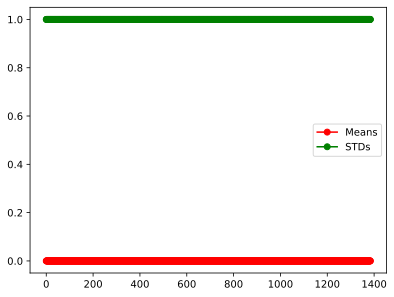

In [168]:
# Now normalise all the features so they are in the same scale and then plot for inspection
Synch_data = (Synch_data - np.mean(Synch_data,axis=0))/np.std(Synch_data,axis=0)
feature_means = np.mean(Synch_data,axis=0)
feature_stds = np.std(Synch_data,axis=0)
plt.plot(feature_means,'ro-',label = 'Means')
plt.plot(feature_stds,'go-',label = 'STDs')
plt.legend()
plt.show()

In [171]:
# convert to tensor - Only for torch

dataT   = torch.tensor( Synch_data ).float()
# label_encoder = LabelEncoder()
# labelsT = label_encoder.fit_transform(Synch_ydat)
# labelsT = torch.tensor( labelsT ).long() # long = int64
labelsT = torch.tensor( Ydat_KL ).float() # long = int64
print(dataT.shape)
devidx = np.random.randint(0,dataT.shape[0],600)
mask = torch.ones(dataT.size(0), dtype=torch.bool)
mask[devidx] = False
devdata = dataT[~mask,:]
devlabels = labelsT[~mask,:]
dataT = dataT[mask,:]
labelsT = labelsT[mask,:]

print(dataT.shape)


# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)
dev_data   = TensorDataset(devdata,devlabels)
dev_loader  = DataLoader(dev_data,batch_size=dev_data.tensors[0].shape[0])

# Step 4: translate into dataloader objects
def CreateBatch(size,train_data,test_data):
    batchsize    = size
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
    return (train_loader,test_loader)


torch.Size([10667, 1385])
torch.Size([10087, 1385])


In [172]:

# create a class for the model
def createModel1():

  class Model1(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(Synch_data.shape[1],1500)
      
      ### hidden layer
      self.fc1 = nn.Linear(1500,2000)
      self.fc2 = nn.Linear(2000,1500)
      self.fc3 = nn.Linear(1500,200)
      self.dropout = nn.Dropout(0.2)

      ### output layer
      self.output = nn.Linear(200,6)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      # x = self.dropout(x)
      x = F.relu( self.fc2(x) )
      # x = self.dropout(x)
      x = F.relu( self.fc3(x) )
      return torch.log_softmax( self.output(x),axis=1 )
  
  # create the model instance
  net = Model1()
  
  # loss function
#   lossfun = nn.NLLLoss()
  lossfun = nn.KLDivLoss(reduction='batchmean')

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=1e-4, weight_decay=1e-4)

  return net,lossfun,optimizer

# test the model with one batch
net,lossfun,optimizer = createModel1()

train_loader,test_loader = CreateBatch(32,train_data,test_data)
X, y = next(iter(train_loader))
yHat = net(X)
# print(yHat)
# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now compute the loss for the single forward pass
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(1.3380, grad_fn=<DivBackward0>)


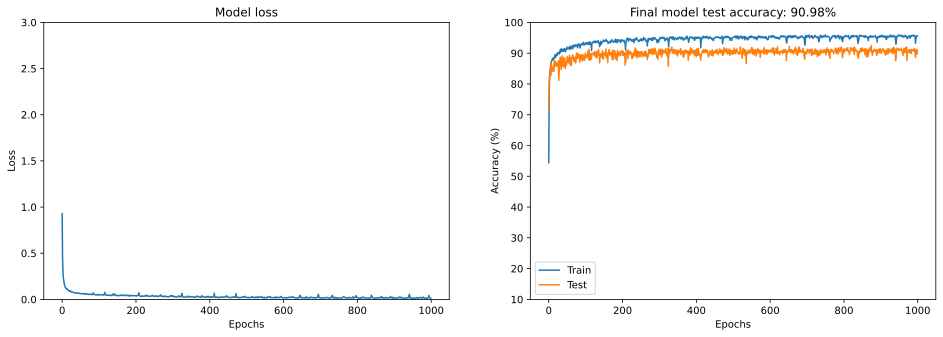

In [173]:
# a function that trains the model
def funtion2trainTheModel():

  # number of epochs
  numepochs = 1000
  
  # create a new model
  net,lossfun,optimizer = createModel1()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []
  
  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)
      

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == torch.argmax(y,axis=1)     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==torch.argmax(y,axis=1)).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Train the model
train_loader,test_loader = CreateBatch(128,train_data,test_data)
trainAcc,testAcc,losses,net = funtion2trainTheModel()

# Plot the training and test accuracies
fig,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [175]:
# run the model through for the test data and print the test KLD
X,y = next(iter(dev_loader))
predictions = net(X).detach()
print(f'Pytorch KLD loss: {lossfun(predictions,y)}')


Pytorch KLD loss: 0.204148069024086


In [176]:
# Save this trained model - the TD features are saved in the dict

torch.save({
    'TD_features': list(onlyfeatures_cleaned.keys()),
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_func': lossfun,
},'/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/Trained_Model1')

In [179]:
# Load the model again just to test if it works. - Everything working okay
Loadedmodel,lossfun,optimizer = createModel1()
modelinfo = torch.load('/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/Trained_Model1')
Loadedmodel.load_state_dict(modelinfo['model_state_dict'])

['T3_mean_before', 'T4_mean_before', 'FR_mean_before', 'FL_mean_before', 'BR_mean_before', 'BL_mean_before', 'CentrFB_mean_before', 'CentrLR_mean_before', 'T3_std_before', 'T4_std_before', 'FR_std_before', 'FL_std_before', 'BR_std_before', 'BL_std_before', 'CentrFB_std_before', 'CentrLR_std_before', 'T3_rng_before', 'T4_rng_before', 'FR_rng_before', 'FL_rng_before', 'BR_rng_before', 'BL_rng_before', 'CentrFB_rng_before', 'CentrLR_rng_before', 'T3_linelength_before', 'T4_linelength_before', 'FR_linelength_before', 'FL_linelength_before', 'BR_linelength_before', 'BL_linelength_before', 'CentrFB_linelength_before', 'CentrLR_linelength_before', 'T3_rms_before', 'T4_rms_before', 'FR_rms_before', 'FL_rms_before', 'BR_rms_before', 'BL_rms_before', 'CentrFB_rms_before', 'CentrLR_rms_before', 'T3_mean_delta_before', 'T4_mean_delta_before', 'FR_mean_delta_before', 'FL_mean_delta_before', 'BR_mean_delta_before', 'BL_mean_delta_before', 'CentrFB_mean_delta_before', 'CentrLR_mean_delta_before', 'T3

<All keys matched successfully>

(10667, 1026)

In [76]:
# Test batch sizes - This takes about 100 minutes to run
sizes = np.array([8,64,128])
finaltestaccuracies = np.empty((3,3))

for idx,size in enumerate(sizes):
    for loop in range(3):
        train_loader,test_loader = CreateBatch(int(size),train_data,test_data)
        print(size)
        trainAcc,testAcc,losses,net = funtion2trainTheModel()

        # run the model through for the dev data and print the test KLD
        X,y = next(iter(dev_loader))
        predictions = net(X).detach()
        finaltestaccuracies[loop,idx] = lossfun(predictions,y)
        

8
8
8
64
64
64
128
128
128


[[0.2111676  0.1916407  0.18943065]
 [0.19829115 0.2104471  0.1808928 ]
 [0.22137207 0.20936587 0.17406189]]


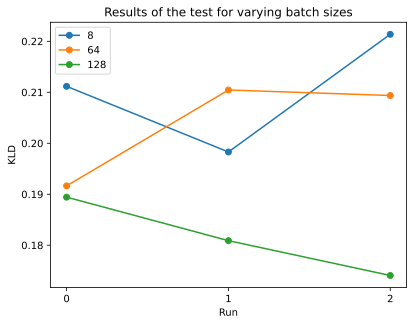

In [89]:
print(finaltestaccuracies)
labels = ['8','64','128']
for i in range(3):
    plt.plot(finaltestaccuracies[:,i],'o-', label = labels[i])
plt.legend()
plt.xlabel('Run')
plt.ylabel('KLD')
plt.xticks([0,1,2])
plt.title('Results of the test for varying batch sizes')
plt.show()

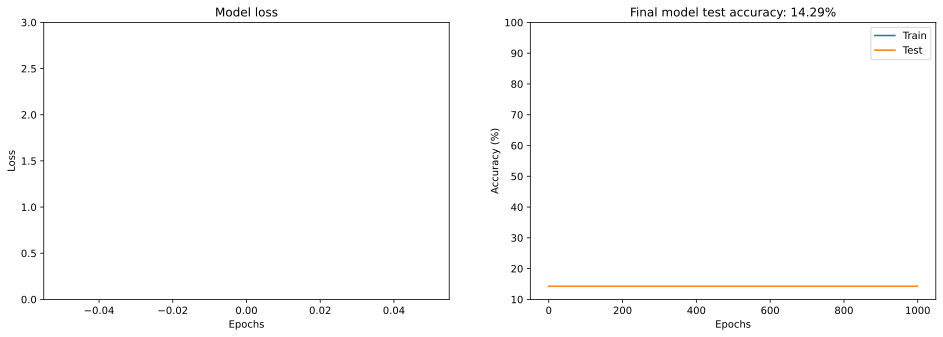

In [56]:

# Plot the training and test accuracies
fig,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [44]:
# run the model through for the test data and print the test KLD
X,y = next(iter(dev_loader))
predictions = net(X).detach()
print(f'Pytorch loss: {lossfun(predictions,y)}')
# print(f'The custom loss is: {kl_divergence_loss(output, target)}')

tensor(1.2928)


Below I try to train a model on the big relatively big dataset but with only the synch data

In [185]:
# Extract only the synchronisation data
Onlysynchdata = Synch_data[:,:1026] 
print(Onlysynchdata.shape)
print(Ydat_KL.shape)

(10667, 1026)
(10667, 6)


In [186]:
# convert to tensor - Only for torch
dataT   = torch.tensor( Onlysynchdata ).float()
labelsT = torch.tensor( Ydat_KL ).float() # long = int64
devidx = np.random.randint(0,dataT.shape[0],600)
mask = torch.ones(dataT.size(0), dtype=torch.bool)
mask[devidx] = False
devdata = dataT[~mask,:]
devlabels = labelsT[~mask,:]
dataT = dataT[mask,:]
labelsT = labelsT[mask,:]

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)
dev_data   = TensorDataset(devdata,devlabels)
dev_loader  = DataLoader(dev_data,batch_size=dev_data.tensors[0].shape[0])

# Step 4: translate into dataloader objects
def CreateBatch(size,train_data,test_data):
    batchsize    = size
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
    return (train_loader,test_loader)


In [187]:

# create a class for the model
def createSynchmodel(Datain):

  class SynchModel(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(Datain.shape[1],1500)
      
      ### hidden layer
      self.fc1 = nn.Linear(1500,2000)
      self.fc2 = nn.Linear(2000,1500)
      self.fc3 = nn.Linear(1500,200)
      self.dropout = nn.Dropout(0.2)

      ### output layer
      self.output = nn.Linear(200,6)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      # x = self.dropout(x)
      x = F.relu( self.fc2(x) )
      # x = self.dropout(x)
      x = F.relu( self.fc3(x) )
      return torch.log_softmax( self.output(x),axis=1 )
  
  # create the model instance
  net = SynchModel()
  
  # loss function
#   lossfun = nn.NLLLoss()
  lossfun = nn.KLDivLoss(reduction='batchmean')

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=1e-4, weight_decay=1e-4)

  return net,lossfun,optimizer

# test the model with one batch
Synch_Net,lossfun,optimizer = createSynchmodel(Onlysynchdata)

train_loader,test_loader = CreateBatch(32,train_data,test_data)
X, y = next(iter(train_loader))
yHat = Synch_Net(X)

# now compute the loss for the single forward pass
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(1.3983, grad_fn=<DivBackward0>)


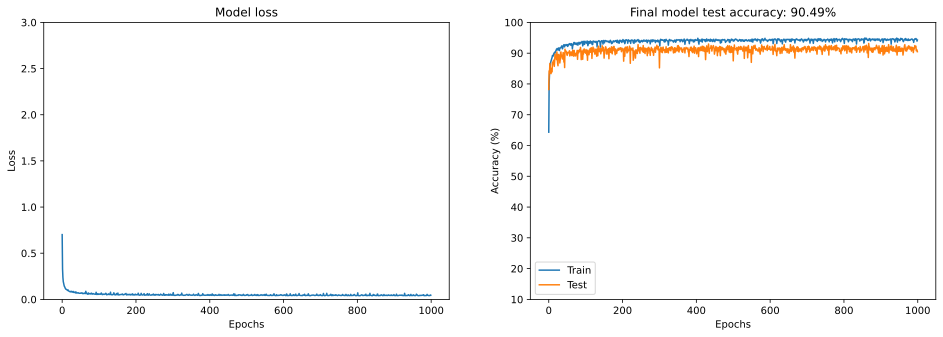

In [190]:
# a function that trains the model
def funtion2trainTheModel():

  # number of epochs
  numepochs = 1000
  
  # create a new model
  net,lossfun,optimizer = createSynchmodel(Onlysynchdata)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []
  
  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)
      

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == torch.argmax(y,axis=1)     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==torch.argmax(y,axis=1)).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Train the model
train_loader,test_loader = CreateBatch(32,train_data,test_data)
trainAcc,testAcc,losses,Synch_net = funtion2trainTheModel()

# Plot the training and test accuracies
fig,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [200]:
# run the model through for the test data and print the test KLD
X,y = next(iter(test_loader))
print(X.shape)
predictions = Synch_net(X).detach()
print(f'Pytorch KLD loss: {lossfun(predictions,y)}')


torch.Size([1009, 1026])
Pytorch KLD loss: 0.1707010269165039


In [192]:
# Save this trained model - the TD features are saved in the dict
torch.save({
    'Train_data': (Onlysynchdata,Ydat_KL),
    'model_state_dict': Synch_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_func': lossfun,
},'/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/Trained_Synch_Net')

Create a new model that takes all features and incorporates Batchnorm and also a slightly higher regularisation parameter

In [100]:
All_feature_path = '/Users/ketanjaltare1/Desktop/Competitions/Combined_Features_wf_all.parquet'
errors_path = '/Users/ketanjaltare1/Desktop/Competitions/Combined_Features_errors.parquet'
# Load the data and remove any columns with NANs - Maybe we can later look at how to use these columns. 
All_features = pd.read_parquet(All_feature_path)
errors = pd.read_parquet(errors_path)

for i in range(len(error_id)):
    All_features.loc[(All_features['eeg_id'] == errors['Error_id'][i]) & (All_features['eeg_label_offset_seconds'] == errors['Error_offset'][i]), Synch_cols] = np.nan


nancols = []
numnans = []
nanrows = set()
for key in All_features.select_dtypes(include=[np.number]).keys():
    if np.any(np.isnan(All_features[key].values)):
        numnans.append(All_features[key].isnull().sum())
        nancols.append(key)

         # Find row indices for NaNs in the current column and update nanrows set
        nan_rows_current_col = All_features[key][All_features[key].isnull()].index.tolist()
        nanrows.update(nan_rows_current_col)

print(f"Columns with NaNs: {nancols}")
print(f"Number of NaNs in each column: {numnans}")
print(f"Row indices with NaNs: {sorted(list(nanrows))}")

All_features_cleaned = All_features.dropna() # There are 3700 rows with NAN values

Y_data = All_features_cleaned.iloc[:,9:15].values
X_cols = All_features_cleaned.iloc[:,15:].select_dtypes(include=[np.number]).keys()
X_data = All_features_cleaned.iloc[:,15:].select_dtypes(include=[np.number]).values


Columns with NaNs: ['T3_hurst_before', 'T4_hurst_before', 'FR_hurst_before', 'FL_hurst_before', 'BR_hurst_before', 'BL_hurst_before', 'CentrFB_hurst_before', 'CentrLR_hurst_before', 'T3_hurst_during', 'T4_hurst_during', 'FR_hurst_during', 'FL_hurst_during', 'BR_hurst_during', 'BL_hurst_during', 'CentrFB_hurst_during', 'CentrLR_hurst_during', 'T3_hurst_after', 'T4_hurst_after', 'FR_hurst_after', 'FL_hurst_after', 'BR_hurst_after', 'BL_hurst_after', 'CentrFB_hurst_after', 'CentrLR_hurst_after', 'Synch0', 'Synch1', 'Synch2', 'Synch3', 'Synch4', 'Synch5', 'Synch6', 'Synch7', 'Synch8', 'Synch9', 'Synch10', 'Synch11', 'Synch12', 'Synch13', 'Synch14', 'Synch15', 'Synch16', 'Synch17', 'Synch18', 'Synch19', 'Synch20', 'Synch21', 'Synch22', 'Synch23', 'Synch24', 'Synch25', 'Synch26', 'Synch27', 'Synch28', 'Synch29', 'Synch30', 'Synch31', 'Synch32', 'Synch33', 'Synch34', 'Synch35', 'Synch36', 'Synch37', 'Synch38', 'Synch39', 'Synch40', 'Synch41', 'Synch42', 'Synch43', 'Synch44', 'Synch45', 'Synch

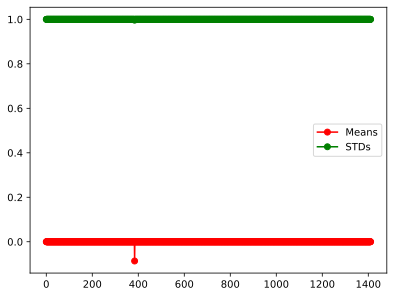

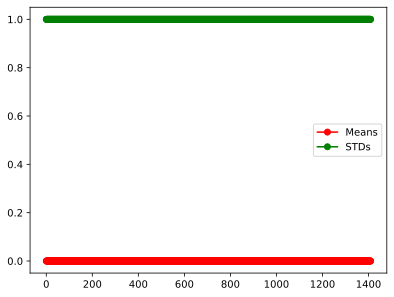

In [101]:
# Now normalise all the features so they are in the same scale and then plot for inspection
Y_data = Y_data / np.sum(Y_data,axis=1,keepdims=True)
X_data = (X_data - np.mean(X_data,axis=0)) / np.std(X_data,axis=0)

feature_means = np.mean(X_data,axis=0)
feature_stds = np.std(X_data,axis=0)
plt.plot(feature_means,'ro-',label = 'Means')
plt.plot(feature_stds,'go-',label = 'STDs')
plt.legend()
plt.show()

X_data = np.delete(X_data,384,1) # Delete the one column where there is a strange value

feature_means = np.mean(X_data,axis=0)
feature_stds = np.std(X_data,axis=0)
plt.plot(feature_means,'ro-',label = 'Means')
plt.plot(feature_stds,'go-',label = 'STDs')
plt.legend()
plt.show()

In [102]:
# convert to tensor - Only for torch

dataT   = torch.tensor( X_data ).float()
labelsT = torch.tensor( Y_data ).float() # long = int64
devidx = np.random.randint(0,dataT.shape[0],int(np.round(dataT.shape[0]*.05)))
mask = torch.ones(dataT.size(0), dtype=torch.bool)
mask[devidx] = False
devdata = dataT[~mask,:]
devlabels = labelsT[~mask,:]
dataT = dataT[mask,:]
labelsT = labelsT[mask,:]

print(f'Train data shape: {dataT.shape}')
print(f'Dev data size: {devdata.shape}')


# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)
dev_data   = TensorDataset(devdata,devlabels)
dev_loader  = DataLoader(dev_data,batch_size=dev_data.tensors[0].shape[0])

# Step 4: translate into dataloader objects
def CreateBatch(size,train_data,test_data):
    batchsize    = size
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
    return (train_loader,test_loader)


Train data shape: torch.Size([98059, 1410])
Dev data size: torch.Size([5041, 1410])


In [103]:

# create a class for the model
def createBnormModel(Datain):

  class BnormModel(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(Datain.shape[1],1500)
      self.bnin = nn.BatchNorm1d(1500)
      ### hidden layers
      self.fc1 = nn.Linear(1500,2000)
      self.bn1 = nn.BatchNorm1d(2000)
      self.fc2 = nn.Linear(2000,1500)
      self.bn2 = nn.BatchNorm1d(1500)
      self.fc3 = nn.Linear(1500,200)
      self.dropout = nn.Dropout(0.2)

      ### output layer
      self.output = nn.Linear(200,6)

    # forward pass
    def forward(self,x):
      x = F.relu( self.bnin(self.input(x)) )
      x = F.relu( self.bn1(self.fc1(x)) )
      # x = self.dropout(x)
      x = F.relu( self.bn2(self.fc2(x)) )
      # x = self.dropout(x)
      x = F.relu( self.fc3(x) )
      return torch.log_softmax( self.output(x),axis=1 )
  
  # create the model instance
  net = BnormModel()
  
  # loss function
#   lossfun = nn.NLLLoss()
  lossfun = nn.KLDivLoss(reduction='batchmean')

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=1e-4, weight_decay=1e-3)

  return net,lossfun,optimizer

# test the model with one batch
Norm_Net,lossfun,optimizer = createBnormModel(X_data)

train_loader,test_loader = CreateBatch(64,train_data,test_data)
X, y = next(iter(train_loader))
yHat = Norm_Net(X)

# now compute the loss for the single forward pass
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(1.3647, grad_fn=<DivBackward0>)


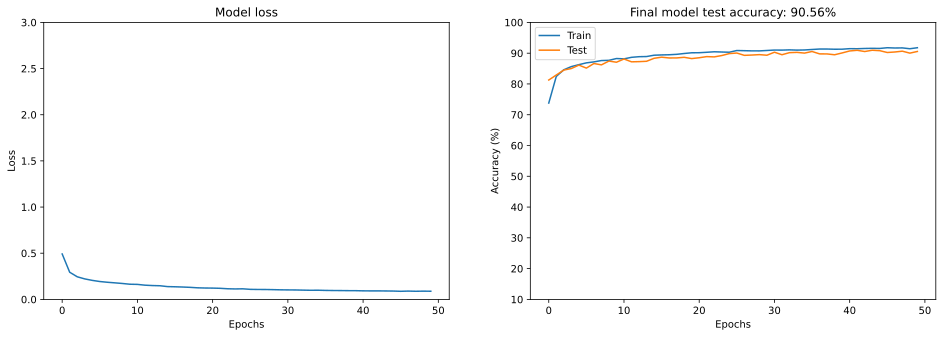

torch.Size([5041, 1410])
Pytorch KLD loss: 0.12922616302967072
Final training loss: 0.08811824023723602


In [105]:
# a function that trains the model
def funtion2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 50

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []
  
  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == torch.argmax(y,axis=1)     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==torch.argmax(y,axis=1)).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Train the model
Norm_Net,lossfun,optimizer = createBnormModel(X_data)
train_loader,test_loader = CreateBatch(64,train_data,test_data)
trainAcc,testAcc,losses,Norm_Net_trained = funtion2trainTheModel(Norm_Net,lossfun,optimizer)

# Plot the training and test accuracies
fig,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# run the model through for the test data and print the test KLD
X,y = next(iter(dev_loader))
predictions = Norm_Net_trained(X).detach()
print(f'Pytorch KLD loss: {lossfun(predictions,y)}')
print(f'Final training loss: {losses[-1]}')

Do some Feature selection if possible. This may reduce computation time when computing the features for the test set.

Try a Convolutional network